In [1]:
import os
import numpy as np
import pandas as pd
import shapefile as shp

import matplotlib
import matplotlib.patches as pch
import matplotlib.pyplot as plt
import matplotlib.backends.backend_pdf as pdf

import cartopy.crs as ccrs
import cartopy.io.shapereader as shpreader

In [2]:
# Watermark is not required for this code, but is included for information. 
import watermark
%load_ext watermark
%watermark -a "ELEANOR LUTZ" -d -v -iv -m

watermark                       1.8.1
matplotlib                      3.0.3
cartopy                         0.17.0
shapefile                       2.0.1
numpy                           1.15.4
pandas                          0.23.4
matplotlib.backends.backend_pdf 3.0.3
ELEANOR LUTZ 2019-08-24 

CPython 3.7.1
IPython 7.2.0

compiler   : MSC v.1900 64 bit (AMD64)
system     : Windows
release    : 10
machine    : AMD64
processor  : Intel64 Family 6 Model 63 Stepping 2, GenuineIntel
CPU cores  : 12
interpreter: 64bit


In [3]:
# Declare variables used throughout this notebook
figsize = (40.007/2, 0.99474216554*20.24/2) # Figure size in inches based on decorative border size
north = [0, 90]
south = [0, -90]
east = [90, 0]
west = [270, 0]

# Create globe with radius of the moon, in meters (EckertIV in Cartopy does not support ellipses)
axis = 1737.1 * 1000
globe = ccrs.Globe(semimajor_axis=axis, semiminor_axis=axis, ellipse=None)
large_proj = ccrs.EckertIV(globe=globe)

color_df = pd.read_csv('./data/Moon_geologic_unit_colors.csv', header=0)
linecolor_df = pd.read_csv('./data/Moon_geologic_boundaries.csv', header=0, index_col='name')

In [4]:
def set_save_image(fig, savename, dpi=600, show=True):
    # Output text as editable PDF text objects instead of shapes
    matplotlib.rcParams['pdf.fonttype'] = 42
    
    # Force PDF to respect zorder by supressing image compositing
    matplotlib.rcParams['image.composite_image'] = False

    # Remove borders on the plot axes
    for ax in fig.get_axes():
        ax.spines['bottom'].set_visible(False)
        ax.spines['left'].set_visible(False)
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        try:
            ax.set_global()
            ax.outline_patch.set_edgecolor('none')
            ax.background_patch.set_facecolor('none')
        except:
            pass 
        
    # Remove all padding and margins
    plt.subplots_adjust(top=1, bottom=0, right=1, left=0, hspace=0, wspace=0)
    plt.margins(0,0)
    plt.gca().xaxis.set_major_locator(matplotlib.pyplot.NullLocator())
    plt.gca().yaxis.set_major_locator(matplotlib.pyplot.NullLocator())
        
    if savename.split('.')[-1] == 'pdf':
        pp = pdf.PdfPages(savename, keep_empty=False)
        pp.savefig(fig)
        pp.close()
    elif savename.split('.')[-1] == 'png':
        plt.savefig(savename, format='png', dpi=dpi, pad_inches=0, transparent=True)
    else:
        print("Unrecognized file format, plot not saved!")

    if show == True: 
        plt.show()
    plt.clf()
    plt.close('all')
    
def make_figure(ch=79):
    # Make each subplot in the exact size that fits into the scrollwork border
    # The variable ch is the distance of each small minimap from the edge of the plot 
    # (I moved this around a bit while experimenting with the design)
    
    fig = plt.figure(figsize=figsize)
    grid = matplotlib.gridspec.GridSpec(6040, 12002)
    ax = fig.add_subplot(grid[40:6000, 40:12002-40], projection=large_proj)
    ax1 = fig.add_subplot(grid[ch:852+ch, ch:852+ch], 
                          projection=ccrs.Orthographic(*north, globe=globe))
    ax2 = fig.add_subplot(grid[ch:852+ch, 12002-(852+ch):12002-ch], 
                          projection=ccrs.Orthographic(*south, globe=globe))
    ax3 = fig.add_subplot(grid[6040-(852+ch):6040-ch, ch:852+ch], 
                          projection=ccrs.Orthographic(*east, globe=globe))
    ax4 = fig.add_subplot(grid[6040-(852+ch):6040-ch, 12002-(852+ch):12002-ch], 
                          projection=ccrs.Orthographic(*west, globe=globe))
    return fig, ax, ax1, ax2, ax3, ax4

In [5]:
# Function to plot different data types from the Lunar data

def plot_data_eckert(datasets, project, color_df, show=False):
    for s in datasets:
        fig, ax0, ax1, ax2, ax3, ax4 = make_figure()
        s2 = s.replace('-','_')
        fname = "./data/Lunar_Geologic_GIS_Renovation_March2013/"+\
            s+"/Shapefiles/"+s2+"_Geology.shp"
        shp = shpreader.Reader(fname)
        
        for record, state in zip(shp.records(), shp.geometries()):
            try:
                name = record.attributes['UnitName']
            except:
                name = record.attributes['UnitName_1']
            colors=set(color_df[(color_df['UnitName']==name) & \
                   (color_df['UnitSymbol']==record.attributes['UnitSymbol'])]['color'].tolist())
            if len(colors) > 1:
                print(colors, name, s)
            if len(colors) == 0:
                facecolor = '#ffffff'
            else:
                facecolor = '#'+list(colors)[0]
            for ax in [ax0, ax1, ax2, ax3, ax4]:
                ax.add_geometries([state], project, facecolor=facecolor, 
                                  edgecolor='none', alpha=1)

        savename = './figures/moon_'+s+'.png'
        set_save_image(fig, savename, show=show)
        print('--- Finished plotting dataset', s, '---')

--- Finished plotting dataset I-0703 ---
--- Finished plotting dataset I-0948 ---
--- Finished plotting dataset I-1034 ---
--- Finished plotting dataset I-1047 ---
--- Finished plotting dataset I-1162 ---


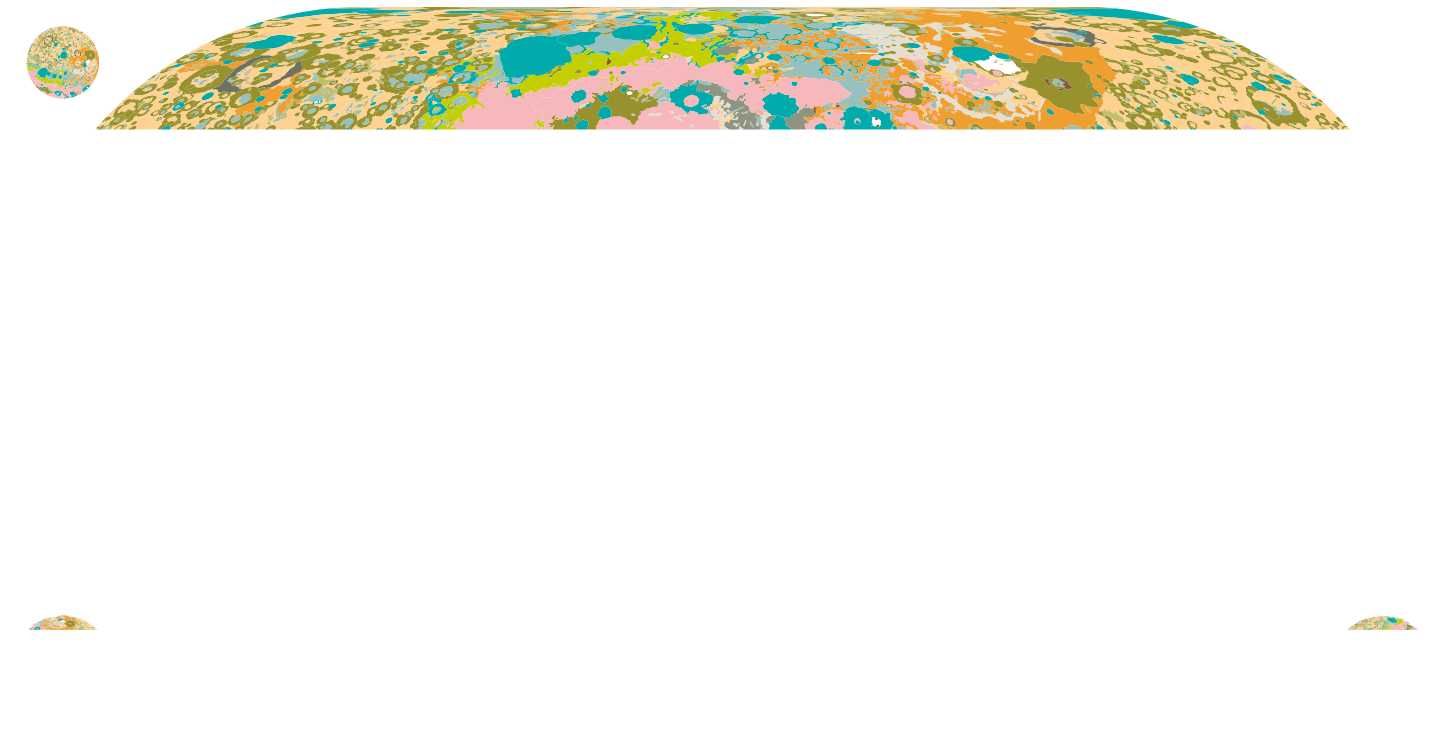

--- Finished plotting dataset I-1062 ---


In [6]:
# Plot all datasets as separate files for the Eckert projection
datasets = ['I-0703', 'I-0948', 'I-1034', 'I-1047']
plot_data_eckert(datasets=datasets, project=ccrs.PlateCarree(), color_df=color_df)
plot_data_eckert(datasets=['I-1162'], project=ccrs.SouthPolarStereo(globe=globe), color_df=color_df)
plot_data_eckert(datasets=['I-1062'], project=ccrs.NorthPolarStereo(globe=globe), color_df=color_df, show=True)

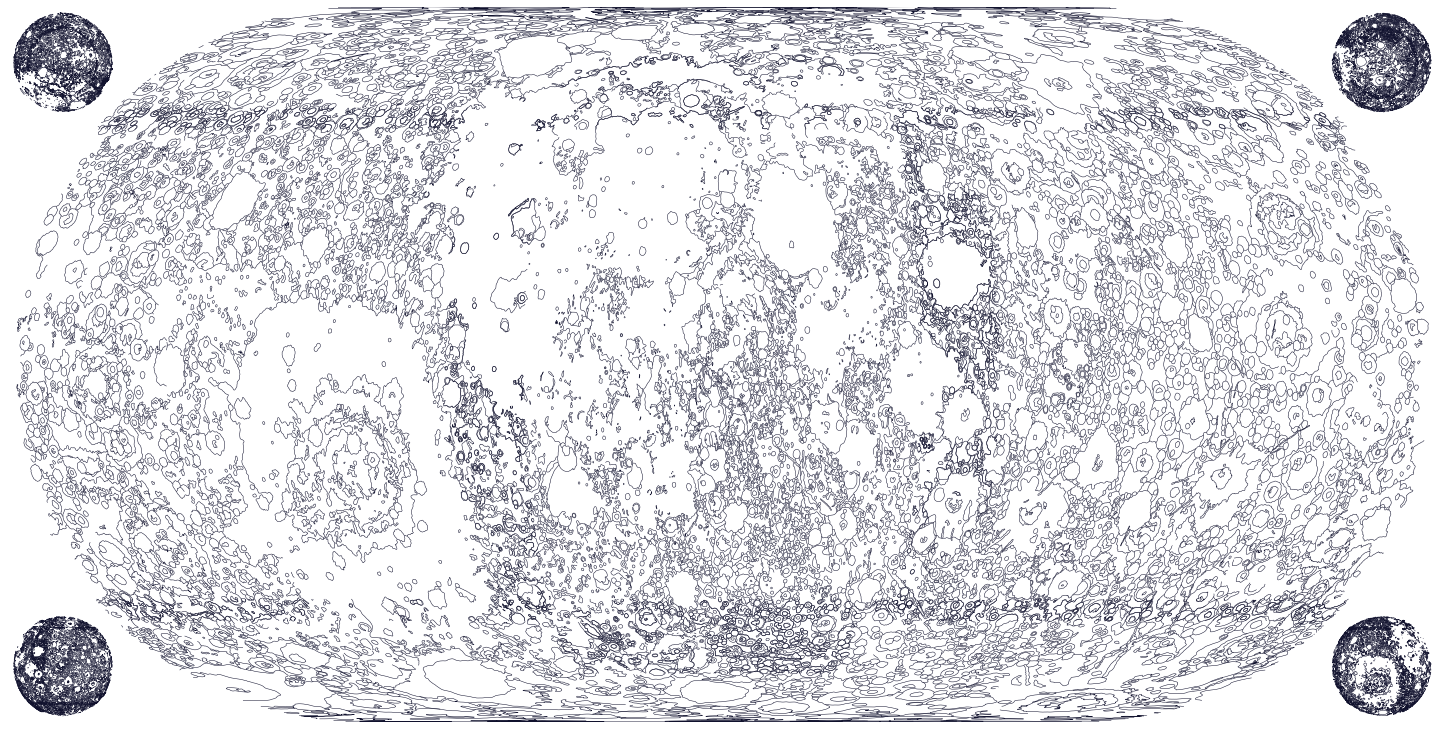

In [7]:
fig, ax0, ax1, ax2, ax3, ax4 = make_figure()
datasets = ['I-0703', 'I-0948', 'I-1034', 'I-1047', 'I-1062', 'I-1162']    
for s in datasets:
    s2 = s.replace('-','_')
    fname = "A:/gitrepos/geology_atlas_of_space/data/Lunar_Geologic_GIS_Renovation_March2013/"+\
        s+"/Shapefiles/"+s2+"_Contacts.shp"
    shp = shpreader.Reader(fname)
    
    for record, state in zip(shp.records(), shp.geometries()):
        try:
            contype = record.attributes['Type'].upper() # don't want to deal with case differences
        except:
            contype = record.attributes['ContactTyp'].upper()
        if contype not in ['MAP BOUNDARY', 'BOUNDARY', 'BORDER', '']:
            facecolor = str(linecolor_df.loc[contype]['color'])
            if facecolor == 'b':
                if s == 'I-1062': 
                    curr_project = ccrs.NorthPolarStereo(globe=globe)
                elif s == 'I-1162':
                    curr_project = ccrs.SouthPolarStereo(globe=globe)
                else:
                    curr_project = ccrs.PlateCarree()
                for ax in [ax0, ax1, ax2, ax3, ax4]:
                    ax.add_geometries([state], curr_project, 
                                      facecolor='none', lw=0.5, edgecolor='#10112d')
    
savename = './figures/moon_contact_lines_certain.png'
set_save_image(fig, savename)

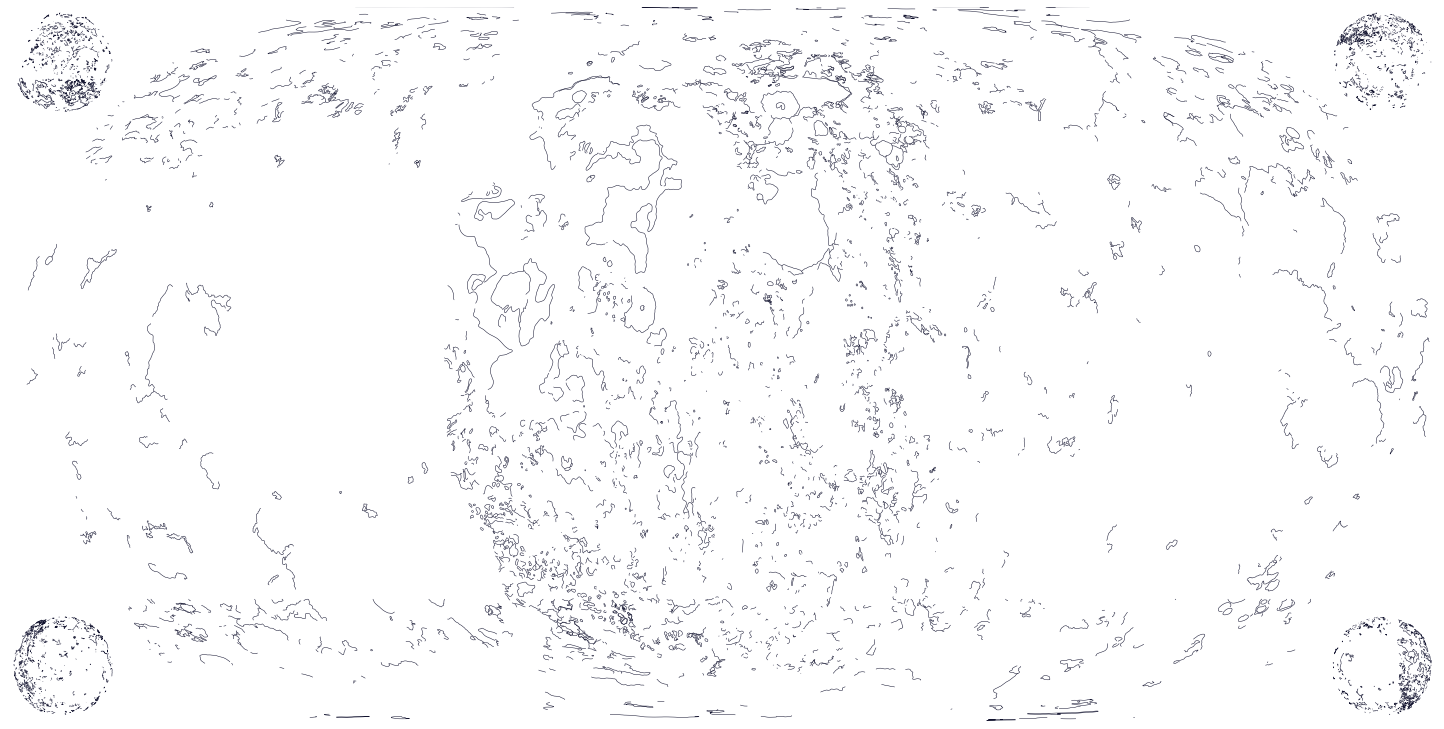

In [8]:
fig, ax0, ax1, ax2, ax3, ax4 = make_figure()
datasets = ['I-0703', 'I-0948', 'I-1034', 'I-1047', 'I-1062', 'I-1162']    
for s in datasets:
    s2 = s.replace('-','_')
    fname = "A:/gitrepos/geology_atlas_of_space/data/Lunar_Geologic_GIS_Renovation_March2013/"+\
        s+"/Shapefiles/"+s2+"_Contacts.shp"
    shp = shpreader.Reader(fname)
    
    for record, state in zip(shp.records(), shp.geometries()):
        try:
            contype = record.attributes['Type'].upper() # don't want to deal with case differences
        except:
            contype = record.attributes['ContactTyp'].upper()
        if contype not in ['MAP BOUNDARY', 'BOUNDARY', 'BORDER', '']:
            facecolor = str(linecolor_df.loc[contype]['color'])
            if facecolor == '#4e2737':
                if s == 'I-1062': 
                    curr_project = ccrs.NorthPolarStereo(globe=globe)
                elif s == 'I-1162':
                    curr_project = ccrs.SouthPolarStereo(globe=globe)
                else:
                    curr_project = ccrs.PlateCarree()
                for ax in [ax0, ax1, ax2, ax3, ax4]:
                    ax.add_geometries([state], curr_project, 
                                      facecolor='none', lw=0.5, edgecolor='#10112d')
    
savename = './figures/moon_contact_lines_uncertain.pdf'
set_save_image(fig, savename)

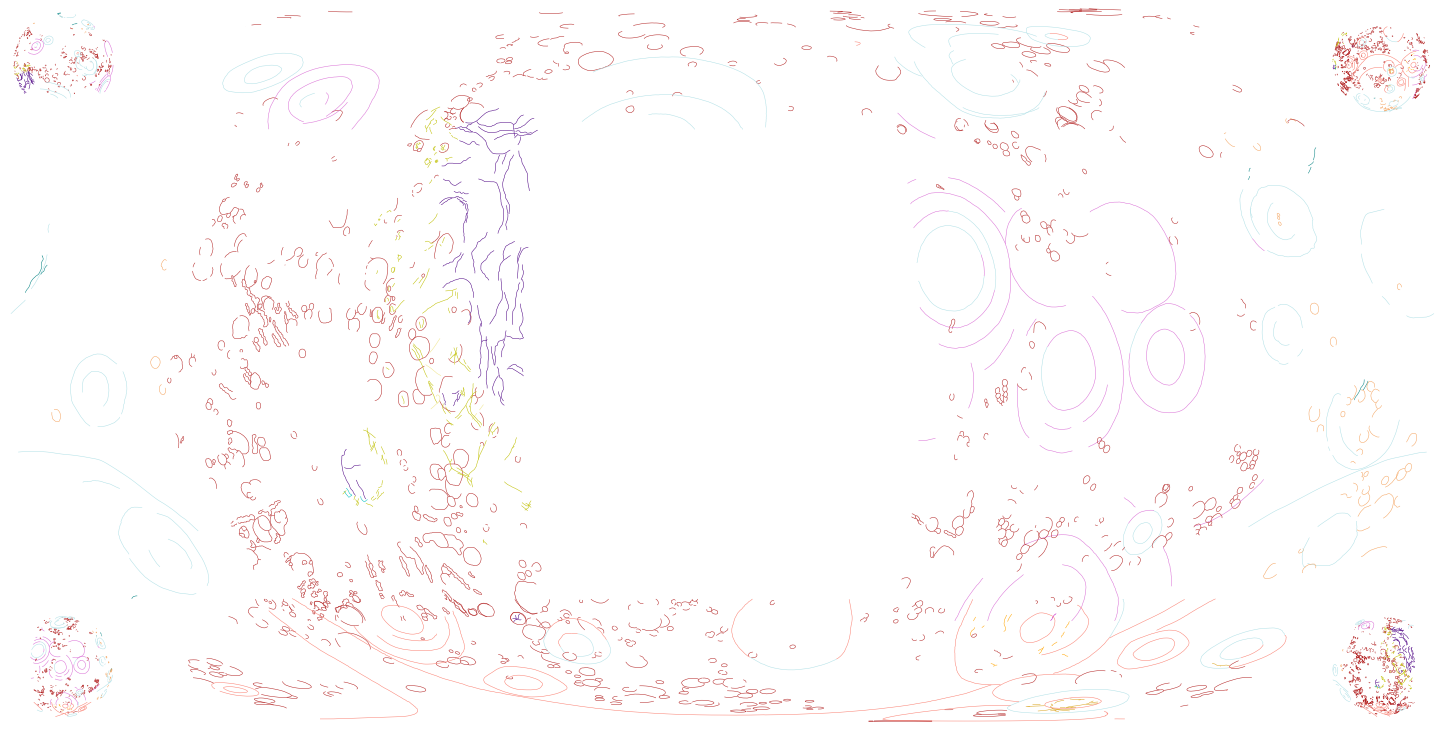

In [9]:
fig, ax0, ax1, ax2, ax3, ax4 = make_figure()
datasets = ['I-0703', 'I-0948', 'I-1034', 'I-1047', 'I-1062', 'I-1162']  

for s in datasets:
    s2 = s.replace('-','_')
    fname1 = "A:/gitrepos/geology_atlas_of_space/data/Lunar_Geologic_GIS_Renovation_March2013/"+\
            s+"/Shapefiles/"+s2+"_Structures.shp"
    fname2 = "A:/gitrepos/geology_atlas_of_space/data/Lunar_Geologic_GIS_Renovation_March2013/"+\
            s+"/Shapefiles/"+s2+"_structure.shp"
    if os.path.isfile(fname1):
        shp = shpreader.Reader(fname1)
    elif os.path.isfile(fname2):
        shp = shpreader.Reader(fname2) 
    
    if os.path.isfile(fname1) or os.path.isfile(fname2):
        for record, state in zip(shp.records(), shp.geometries()):
            contype = record.attributes['StructureT'].upper()
            if contype not in ['APOLLO 16 LASER ALTIMETRY', 'APOLLO 15 LUNAR ALTIMETRY']:
                facecolor = str(linecolor_df.loc[contype]['color'])
                if s == 'I-1062': 
                    curr_project = ccrs.NorthPolarStereo(globe=globe)
                elif s == 'I-1162':
                    curr_project = ccrs.SouthPolarStereo(globe=globe)
                else:
                    curr_project = ccrs.PlateCarree()
                for ax in [ax0, ax1, ax2, ax3, ax4]:
                    ax.add_geometries([state], curr_project, 
                                      facecolor='none', lw=0.5, edgecolor=facecolor)

savename = './figures/moon_structures.pdf'
set_save_image(fig, savename)

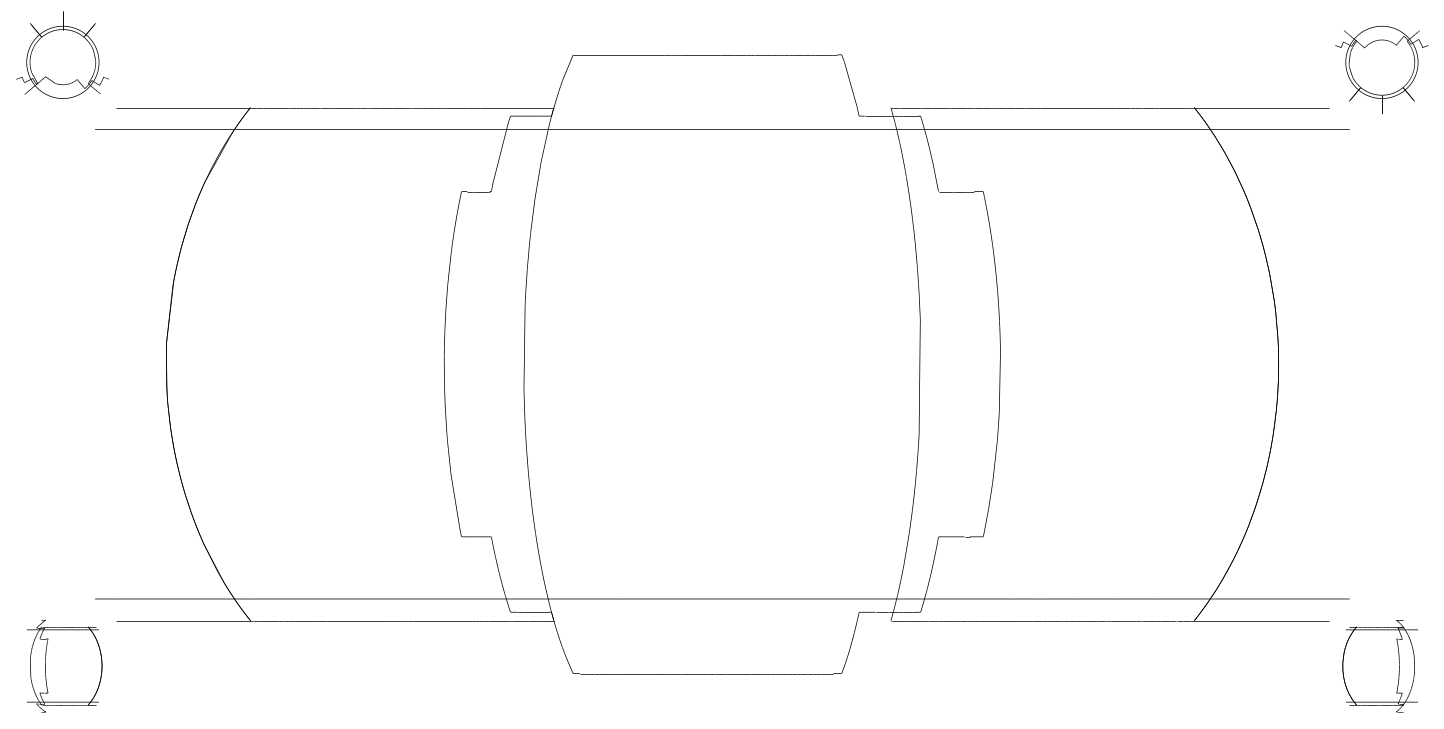

In [10]:
fig, ax0, ax1, ax2, ax3, ax4 = make_figure()
datasets = ['I-0703', 'I-0948', 'I-1034', 'I-1047', 'I-1062', 'I-1162']    

for s in datasets:
    s2 = s.replace('-','_')
    fname = "A:/gitrepos/geology_atlas_of_space/data/Lunar_Geologic_GIS_Renovation_March2013/"+s\
        +"/Shapefiles/"+s2+"_Contacts.shp"
    shp = shpreader.Reader(fname)
    
    for record, state in zip(shp.records(), shp.geometries()):
        try:
            contype = record.attributes['Type']
        except:
            contype = record.attributes['ContactTyp']
        if contype in ['Map boundary', 'Boundary', 'Border']:
            if s == 'I-1062': 
                curr_project = ccrs.NorthPolarStereo(globe=globe)
            elif s == 'I-1162':
                curr_project = ccrs.SouthPolarStereo(globe=globe)
            else:
                curr_project = ccrs.PlateCarree()
            for ax in [ax0, ax1, ax2, ax3, ax4]:
                ax.add_geometries([state], curr_project, facecolor='none', edgecolor='k', lw=0.75)
            
savename = './figures/moon_borders.png'
set_save_image(fig, savename)

In [11]:
# Create a dataframe of colors and moon feature types for future reference

features = pd.read_csv('./data/moon_features.csv')
fset = features.groupby('Feature_Type_Code').count().sort_values(by='Feature_ID', ascending=False)
display(fset.head(5))

features = features.drop_duplicates(subset=['Feature_Type_Code'], keep="first")
features = features[['Feature_Type_Code', 'Feature_Type']]
features.sort_values(by="Feature_Type_Code", inplace=True)
features['Feature_Type_Code'] = features['Feature_Type_Code'].str.strip()

chars = [x for x in '0123456789ABCDEF']
colors = ['#'+''.join(np.random.choice(chars, size=6)) for i in range(len(features))]
features['color'] = colors
features.to_csv('./data/moon_feature_colors.csv', index=False)

,Feature_ID,Feature_Name,Clean_Feature_Name,Target,Diameter,Center_Latitude,Center_Longitude,Northern_Latitude,Southern_Latitude,Eastern_Longitude,...,Continent,Ethnicity,Feature_Type,Quad,Approval_Status,Approval_Date,Reference,Origin,Additional_Info,Last_Updated
Feature_Type_Code,,,,,,,,,,,,,,,,,,,,,
SF,7060,7060,7060,7060,7060,7060,7060,7060,7060,7060,...,7060,7060,7060,7060,7060,7060,6186,7060,30,7060
AA,1575,1575,1575,1575,1575,1575,1575,1575,1575,1575,...,1572,1572,1575,1570,1575,1575,1068,1575,53,1575
RI,111,111,111,111,111,111,111,111,111,111,...,111,111,111,111,111,111,71,111,0,111
LF,83,83,83,83,83,83,83,83,83,83,...,83,83,83,83,83,83,81,83,0,83
MO,48,48,48,48,48,48,48,48,48,48,...,47,47,48,48,48,48,28,48,1,48


0 duplicate values dropped from dataset


Feature_Type_Code,AA,SF,RI,DO,ME,MO,LC,CA,VA,SI,RU,PA,AL,OC,PR
Feature_ID,489,105,70,31,22,18,17,13,12,11,6,3,1,1,1


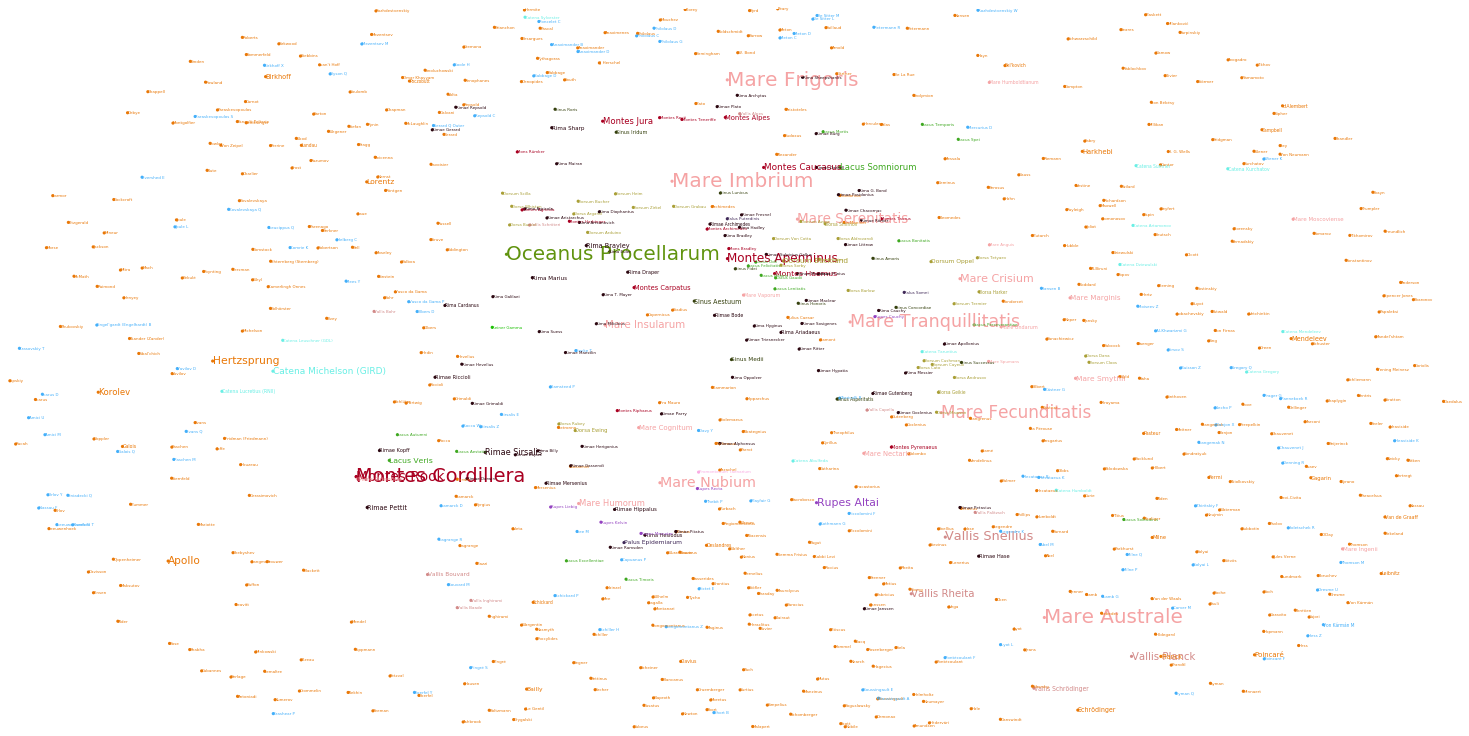

In [12]:
# Typography of moon futures

savename = './figures/moon_features.pdf'

features = pd.read_csv('./data/moon_features.csv')
check = len(features)
features = features.drop_duplicates(subset=['Feature_ID'])
print(check - len(features), "duplicate values dropped from dataset")

fig = plt.figure(figsize=figsize)
ax = plt.axes(projection=large_proj)  
ax.set_global()

colors = pd.read_csv('./data/moon_feature_colors.csv', index_col='Feature_Type_Code')
features.sort_values(by=["Diameter"], inplace=True, ascending=False)
features = features.head(min(800, len(features)))
for index, row in features.iterrows():
    text = row['Feature_Name']
    x, y, s = row['Center_Longitude'], row['Center_Latitude'], row['Diameter']
    c = colors.loc[row['Feature_Type_Code'].strip()]['color']
    ax.text(x, y, text, transform=ccrs.PlateCarree(), 
            ha='left', va='center', fontsize=min(max(4, s/50), 20), color=c)
    ax.scatter(x, y, transform=ccrs.PlateCarree(), s=10, color=c, edgecolor='None', lw=0)
    
fset = features.groupby('Feature_Type_Code').count().sort_values(by='Feature_ID', 
         ascending=False)[['Feature_ID']].transpose()
display(fset)

set_save_image(fig, savename)

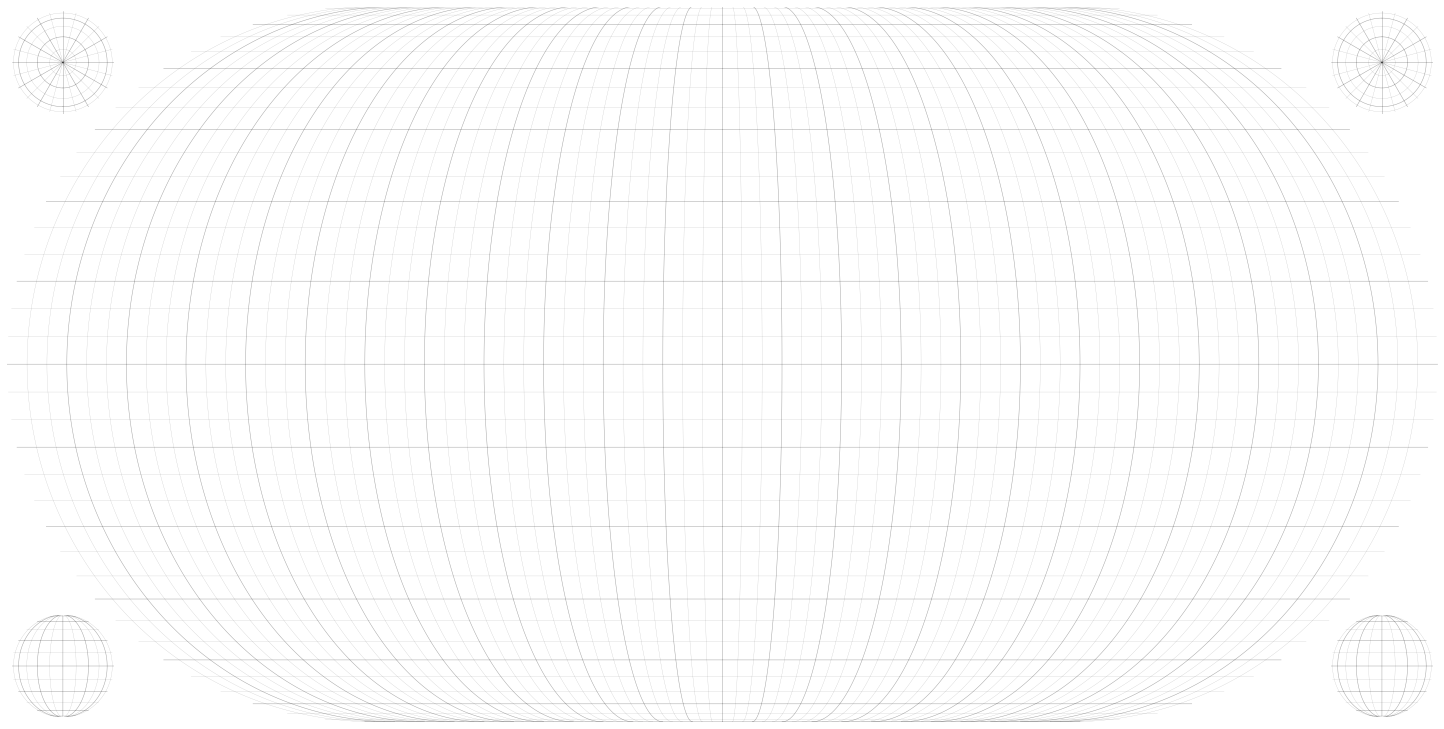

In [14]:
# Plot gridlines

savename = './figures/moon_gridlines.png'

fig, ax, ax1, ax2, ax3, ax4 = make_figure()
lon_large = np.arange(0, 360, 30)
lon_small = np.arange(0, 360, 15)
lon_mini = np.arange(0, 360, 5)
lat_large = np.arange(-90, 91, 30)
lat_small = np.arange(-90, 91, 15)
lat_mini = np.arange(-90, 91, 5)
lat_delim = np.arange(-90, 90.01, 0.1)
lon_delim = np.arange(0, 360, 0.1)

for a in [ax1, ax2, ax3, ax4]:
    for lg in lat_large: 
        a.plot(lon_delim, [lg]*len(lon_delim), transform=ccrs.PlateCarree(), 
               color='k', lw=0.5, alpha=0.35)
    for sm in lat_small: 
        if sm not in lat_large: 
            a.plot(lon_delim, [sm]*len(lon_delim), transform=ccrs.PlateCarree(), 
                   color='k', lw=0.25, alpha=0.25)
    for lg in lon_large: 
        a.plot([lg]*len(lat_delim), lat_delim, transform=ccrs.PlateCarree(), 
               color='k', lw=0.5, alpha=0.35)
    for sm in lon_small: 
        if sm not in lon_large: 
            a.plot([sm]*len(lat_delim), lat_delim, transform=ccrs.PlateCarree(), 
                   color='k', lw=0.25, alpha=0.25)

for lg in lat_small: 
    ax.plot(lon_delim, [lg]*len(lon_delim), transform=ccrs.PlateCarree(), 
            color='k', lw=0.5, alpha=0.35)
for sm in lat_mini: 
    if sm not in lat_small: 
        ax.plot(lon_delim, [sm]*len(lon_delim), transform=ccrs.PlateCarree(), 
                color='k', lw=0.25, alpha=0.25)
for lg in lon_small: 
    ax.plot([lg]*len(lat_delim), lat_delim, transform=ccrs.PlateCarree(), 
            color='k', lw=0.5, alpha=0.35)
for sm in lon_mini: 
    if sm not in lon_small: 
        ax.plot([sm]*len(lat_delim), lat_delim, transform=ccrs.PlateCarree(), 
                color='k', lw=0.25, alpha=0.25)

set_save_image(fig, savename)

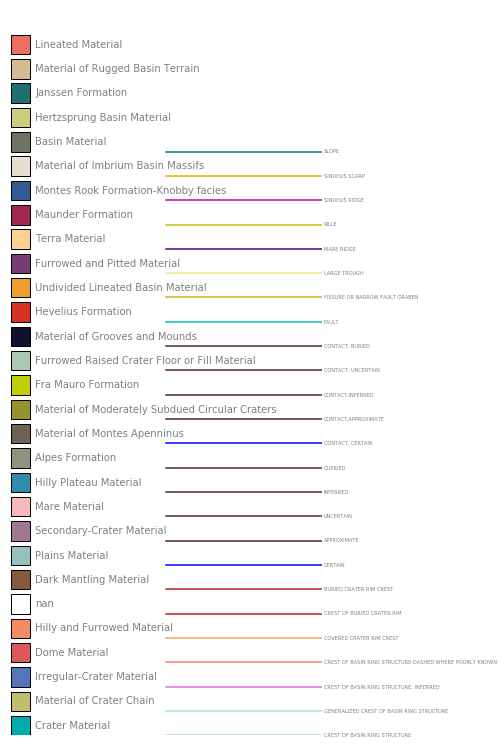

In [13]:
# Print color key for reference 

savename = './figures/moon_key.pdf'

fig = plt.figure(figsize=figsize)
ax = fig.add_subplot(111)
ax.set_aspect("equal")
match = 1.25

# Plot key for colors
df = pd.read_csv('./data/Moon_geologic_unit_colors.csv')
df = df.drop_duplicates(subset=['color'], keep='first')
for ii, (index, row) in enumerate(df.iterrows()): 
    ax.add_patch(pch.Rectangle((0, match*ii), width=1, height=1, 
                               facecolor='#'+str(row['color']), edgecolor='k'))
    ax.text(1.25, match*ii+0.5, row['UnitName'], ha='left', 
            va='center', fontsize=10, alpha=0.5)
ax.set_ylim(0, match*len(df)+1)    

# Plot key for boundaries
df = pd.read_csv('./data/Moon_geologic_boundaries.csv')
for ii, (index, row) in enumerate(df.iterrows()): 
    ax.plot([8, 16], [match*ii, match*ii], color=row['color'])
    ax.text(16.1, match*ii, row['name'], ha='left', 
            va='center', fontsize=5, alpha=0.5)

set_save_image(fig, savename)